In [1]:
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

In [2]:
get_price("000001.XSHE", start_date="2017-01-01", end_date="2017-01-06")

,volume,total_turnover,close,limit_up,low,high,limit_down,open,num_trades
2017-01-03,45984049.0,4.205952e+08,8.7922,9.6081,8.7250,8.8114,7.8612,8.7442,13730.0
2017-01-04,44932953.0,4.115034e+08,8.7922,9.6753,8.7730,8.8114,7.9092,8.7826,11850.0
2017-01-05,34437291.0,3.157697e+08,8.8018,9.6753,8.7826,8.8114,7.9092,8.8018,11764.0
2017-01-06,35815420.0,3.271764e+08,8.7634,9.6849,8.7442,8.8018,7.9187,8.8018,14671.0


In [3]:
price = get_price(['000024.XSHE', '000001.XSHE', '000002.XSHE'], start_date='2015-04-01', end_date='2015-04-12')

In [6]:
# pandas  panel
price

<class 'pandas.core.panel.Panel'>
Dimensions: 9 (items) x 7 (major_axis) x 3 (minor_axis)
Items axis: volume to num_trades
Major_axis axis: 2015-04-01 00:00:00 to 2015-04-10 00:00:00
Minor_axis axis: 000001.XSHE to 000002.XSHE

In [7]:
get_trading_dates(start_date="2017-01-01", end_date="2018-01-01")

[datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 4),
 datetime.date(2017, 1, 5),
 datetime.date(2017, 1, 6),
 datetime.date(2017, 1, 9),
 datetime.date(2017, 1, 10),
 datetime.date(2017, 1, 11),
 datetime.date(2017, 1, 12),
 datetime.date(2017, 1, 13),
 datetime.date(2017, 1, 16),
 datetime.date(2017, 1, 17),
 datetime.date(2017, 1, 18),
 datetime.date(2017, 1, 19),
 datetime.date(2017, 1, 20),
 datetime.date(2017, 1, 23),
 datetime.date(2017, 1, 24),
 datetime.date(2017, 1, 25),
 datetime.date(2017, 1, 26),
 datetime.date(2017, 2, 3),
 datetime.date(2017, 2, 6),
 datetime.date(2017, 2, 7),
 datetime.date(2017, 2, 8),
 datetime.date(2017, 2, 9),
 datetime.date(2017, 2, 10),
 datetime.date(2017, 2, 13),
 datetime.date(2017, 2, 14),
 datetime.date(2017, 2, 15),
 datetime.date(2017, 2, 16),
 datetime.date(2017, 2, 17),
 datetime.date(2017, 2, 20),
 datetime.date(2017, 2, 21),
 datetime.date(2017, 2, 22),
 datetime.date(2017, 2, 23),
 datetime.date(2017, 2, 24),
 datetime.date(2017, 2, 

In [8]:
# 获取财务数据
q = query(fundamentals.income_statement.revenue,
         fundamentals.income_statement.cost_of_goods_sold
         ).filter(fundamentals.stockcode.in_(['000024.XSHE', '000001.XSHE']))
fund = get_fundamentals(q, entry_date="2017-01-03")

/usr/local/lib/python3.6/site-packages/rqdatac/services/financial.py:339: UserWarning: Panel will be deprecated. Please use 'expect_df=True' to get a MultiIndex DataFrame.
  warnings.warn("Panel will be deprecated. Please use 'expect_df=True' to get a MultiIndex DataFrame.")


In [9]:
q = query(fundamentals.income_statement.revenue,
         fundamentals.income_statement.cost_of_goods_sold
         )
fund = get_fundamentals(q, entry_date="2017-01-03")

In [10]:
# 换成截面数据
fund[:, 0, :] # 截面数据，DataFrame，股票代号、列指标名字

TypeError: cannot do index indexing on <class 'pandas.core.indexes.datetimes.DatetimeIndex'> with these indexers [0] of <class 'int'>

In [25]:
# 对pe_ration进行去极值
fund = get_fundamentals(query(fundamentals.eod_derivative_indicator.pe_ratio), entry_date="20180102")[:, 0, :]

In [29]:
fund['pe_ration_winsorize'] = winsorize(fund['pe_ratio'], limits=0.025)

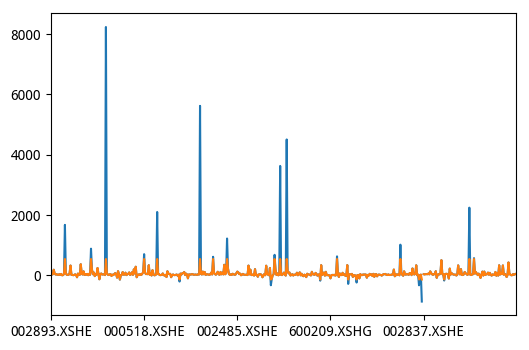

In [34]:
fund['pe_ratio'][:500].plot()
fund['pe_ration_winsorize'][:500].plot()

In [36]:
def quantile(factor,up,down): 
  """自实现分位数去极值"""
  up_scale = np.percentile(factor, up)   
  down_scale = np.percentile(factor, down)   
  factor = np.where(factor > up_scale, up_scale, factor)   
  factor = np.where(factor < down_scale, down_scale, factor)  
  return factor

In [39]:
quantile(fund['pe_ratio'], 97.5, 2.5)

array([60.9084, 28.729800000000001, 38.923499999999997, ..., 104.4151,
       203.64580000000001, 22.5595], dtype=object)

In [40]:
def mad(factor):
  """
  实现3倍中位数绝对偏差去极值
  """
  # 1、找出因子的中位数 median
  me = np.median(factor)
  
  # 2、得到每个因子值与中位数的绝对偏差值 |x – median|
  # 3、得到绝对偏差值的中位数， MAD，median(|x – median|)
  # np.median(abs(factor - me))就是MAD
  mad = np.median(abs(factor - me))
  
  # 4、计算MAD_e = 1.4826*MAD，然后确定参数 n，做出调整
  # 求出3倍中位数上下限制
  up = me + (3 * 1.4826 * mad)
  down = me - (3 * 1.4826 * mad)
  
  # 利用3倍中位数的值去极值
  factor = np.where(factor > up, up, factor)
  factor = np.where(factor < down, down, factor)
  return factor

In [41]:
# 对pe_ratio去极值
fund['pe_ratio_3mad'] = mad(fund['pe_ratio'])

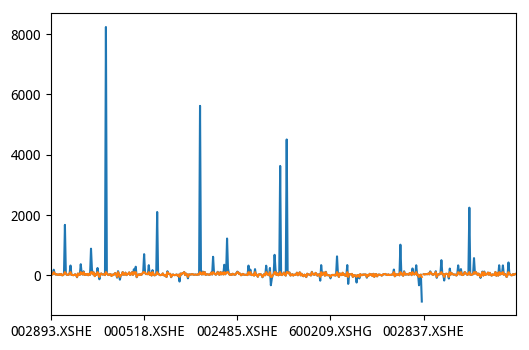

In [42]:
fund['pe_ratio'][:500].plot()
fund['pe_ratio_3mad'][:500].plot()

In [52]:
def threesigma(factor):
  """3sigma方法去极值
  """
  # 计算平均值和标准差
  mean = factor.mean()
  std = factor.std()
  
  # 计算上下限的数据
  up = mean + 3 * std
  
  down = mean - 3 * std
  
  # 替换极值
  factor = np.where(factor > up, up, factor)
  factor = np.where(factor < down, down, factor)
  
  return factor

In [53]:
fund['pe_ratio_3sigma'] = threesigma(fund['pe_ratio'])

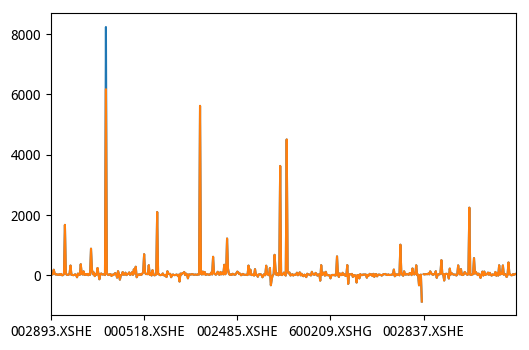

In [54]:
fund['pe_ratio'][:500].plot()
fund['pe_ratio_3sigma'][:500].plot()

In [58]:
# 2、标准化处理
std = StandardScaler()

In [62]:
std.fit_transform(fund['pe_ratio_3mad'].dropna())

/opt/conda/envs/ricequant/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/opt/conda/envs/ricequant/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/envs/ricequant/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.61154875, -0.19356139,  0.06148548, ...,  1.70008851,
        1.82699859, -0.3479426 ])

In [63]:
def stand(factor):
  """自实现标准化
  """
  mean = factor.mean()
  std = factor.std()
  
  return (factor - mean ) / std

In [65]:
fund['pe_ration_stand'] = stand(fund['pe_ratio_3mad'])

In [66]:
fund

,pe_ratio,pe_ration_winsorize,pe_ratio_3mad,pe_ratio_3sigma,pe_ration_stand
002893.XSHE,60.9084,60.9084,60.9084,60.9084,0.611461
600977.XSHG,28.7298,28.7298,28.7298,28.7298,-0.193533
002074.XSHE,38.9235,38.9235,38.9235,38.9235,0.0614766
002184.XSHE,189.209,189.209,109.487,189.209,1.82674
603042.XSHG,64.483,64.483,64.483,64.483,0.700884
002075.XSHE,29.9032,29.9032,29.9032,29.9032,-0.164179
002182.XSHE,43.9879,43.9879,43.9879,43.9879,0.18817
002183.XSHE,22.7842,22.7842,22.7842,22.7842,-0.342271
002416.XSHE,17.1886,17.1886,17.1886,17.1886,-0.482253
300477.XSHE,40.505,40.505,40.505,40.505,0.10104


In [ ]:
# 获取两个因子数据
# 对目标值因子-市净率进行去极值、标准化处理
# 建立市值与市净率回归方程
# 通过回归系数，预测新的因子结果y_predict
# 求出市净率与y_predict的偏差即为新的因子值

In [69]:
# 1、 获取数据
q = query(fundamentals.eod_derivative_indicator.pb_ratio,
         fundamentals.eod_derivative_indicator.market_cap)

fund = get_fundamentals(q, entry_date="2018-01-03")[:, 0, :]

In [71]:
# 2、对因子数据进行处理,3倍中位数、stand
fund['pb_ratio'] = mad(fund['pb_ratio'])
fund['pb_ratio'] = stand(fund['pb_ratio'])

In [ ]:
# 对于市值因子可以选择处理

In [75]:
# 3、确定建立回归方程特征值和目标值
# 传入训练的特征值是二维的形状
x = fund['market_cap'].reshape(-1, 1)
y = fund['pb_ratio']

/opt/conda/envs/ricequant/bin/rq-research-kernel:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [76]:
# 4、利用线性回归进行预测
lr = LinearRegression()
lr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [79]:
# 5、得出每个预测值，让因子的真实值-预测值得出的误差，就为我们中性化处理之后的结果
y_predict = lr.predict(x)

In [82]:
res = y - y_predict

In [84]:
fund['pb_ratio'] = res

In [85]:
fund

,pb_ratio,market_cap
601211.XSHG,-0.952216,1.67133e+11
002705.XSHE,-0.462954,1.04364e+10
300531.XSHE,1.73412,4.494e+09
300363.XSHE,0.152555,5.67849e+09
600977.XSHG,-0.442247,2.90692e+10
002843.XSHE,0.62334,3.13996e+09
002707.XSHE,0.169109,9.29116e+09
601579.XSHG,-0.848725,5.98324e+09
002748.XSHE,-0.307348,3.6456e+09
300373.XSHE,1.09656,1.39385e+10
